In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import mpld3

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

In [8]:
import GenomicWindows
from GenomicWindows import window
import importlib
importlib.reload(GenomicWindows)
import pandas
from pandas import DataFrame
import numpy

window_size = 1000000
@window(size=window_size, fill={'nr_tracts': 0, 'tot_len': 0, 'admix_prop': 0})
def stats(df):
    return {'nr_tracts': df.start.count(), 
            'tot_len': sum(df.end-df.start), 
            'admix_prop': sum(df.end-df.start) / window_size}
    
windowed_data = (pandas.read_table('/Users/kmt/Downloads/Simon_X.txt')
                 .groupby(['name', 'population', 'region'])
                 .apply(stats)
                 .reset_index()
                )

In [9]:
windowed_data.head()

,name,population,region,level_3,start,end,nr_tracts,tot_len,admix_prop
0,S_Abkhasian-1,Abkhasian,WestEurasia,0,0,1000000,0,0,0.000
1,S_Abkhasian-1,Abkhasian,WestEurasia,1,1000000,2000000,0,0,0.000
2,S_Abkhasian-1,Abkhasian,WestEurasia,2,2000000,3000000,1,45000,0.045
3,S_Abkhasian-1,Abkhasian,WestEurasia,3,3000000,4000000,0,0,0.000
4,S_Abkhasian-1,Abkhasian,WestEurasia,4,4000000,5000000,0,0,0.000


In [10]:
from pathlib import Path
import os, sys
root_dir = Path(os.environ['HOME'], 'GenomeDK', 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'GenomeDK', 'simons/faststorage/data/metadata')

scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data

individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

In [28]:
windowed_data.admix_prop.mean()

0.0062288659793814424

['WestEurasia', 'CentralAsiaSiberia', 'SouthAsia', 'America', 'EastAsia', 'Oceania']


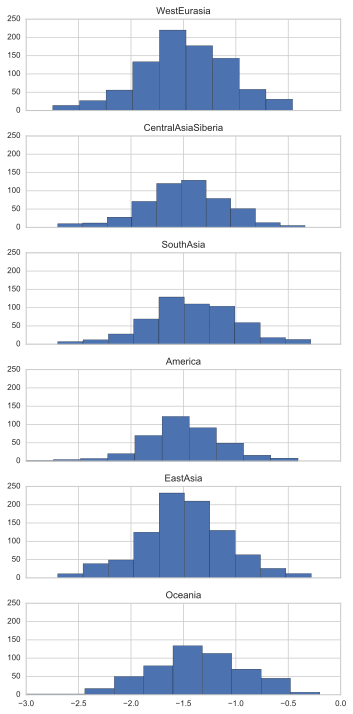

In [48]:
admixture_regions = [x for x in regions if x != 'Africa']

df = windowed_data.loc[windowed_data.admix_prop > 0].assign(log_admix_prop=lambda df: numpy.log10(df.admix_prop))

fig, axarr = plt.subplots(len(admixture_regions), sharey=True, sharex=True, figsize=(5,10))
#fig, axarr = plt.subplots(1, len(admixture_regions), sharey=True)
for ax, region in zip(axarr, admixture_regions):    
    ax.hist(df.loc[lambda df: df.region == region, 'log_admix_prop'], normed=False, bins=10)
    ax.set_title(region)
plt.tight_layout()

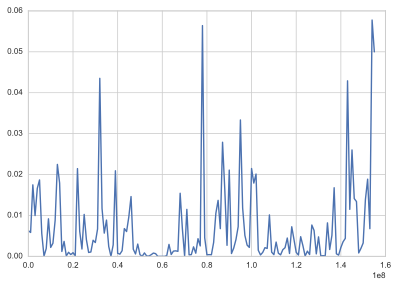

In [73]:
global_means = windowed_data.groupby(['start']).aggregate('mean').reset_index()
#global_means.head()
plt.plot(global_means.start, global_means.admix_prop)

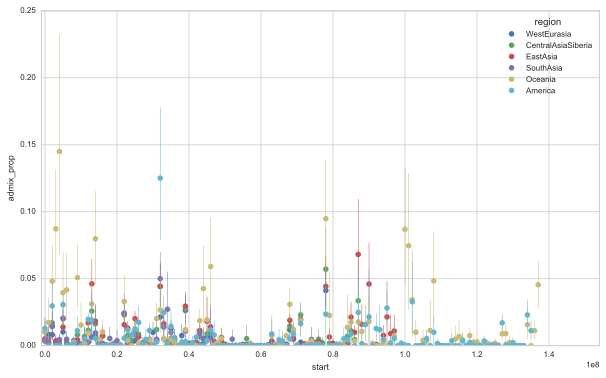

In [90]:
fig, ax = plt.subplots(figsize=(10, 6))
with sns.plotting_context('paper', font_scale=1, rc={"lines.linewidth": 0.5}): # paper, notebook, talk”, poster
    g = sns.tsplot(data=windowed_data, time='start', value='admix_prop', 
           unit='name', condition='region', 
           err_style="ci_bars", 
           ci=[95], 
           interpolate=False, ax=ax)